In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
%matplotlib inline
from utils import preprocess

In [3]:
import numpy as np
import pandas as pd
import os

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input

Using TensorFlow backend.


In [6]:
DATA_PATH = os.path.join('../data')
TRAIN_FILE = os.path.join(DATA_PATH, 'train.csv')
TEST_FILE = os.path.join(DATA_PATH, 'test.csv')

In [73]:
train_features = preprocess(TRAIN_FILE)

In [74]:
train_features['bearing'] = train_features['bearing']/360.
train_features['h_dist'] = np.log(train_features['h_dist'] + 1.0)
train_features['cluster_dist'] = np.log(train_features['cluster_dist'] + 1.0)

In [75]:
train_features.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter', u'weekday',
       u'holiday', u'st_dist', u'h_dist', u'bearing', u's_pickup_latitude',
       u's_pickup_longitude', u's_dropoff_latitude', u's_dropoff_longitude',
       u'flag', u'month_end', u'month_start', u'pickup_cluster_label',
       u'dropoff_cluster_label', u'pickup_cluster_longitude',
       u'pickup_cluster_latitude', u'dropoff_cluster_longitude',
       u'dropoff_cluster_latitude', u'cluster_dist',
       u's_pickup_cluster_latitude', u's_pickup_cluster_longitude',
       u's_dropoff_cluster_latitude', u's_dropoff_cluster_longitude'],
      dtype='object')

In [76]:
categorical_features = [u'vendor_id', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'pickup_cluster_label',
       u'dropoff_cluster_label']

for feature in categorical_features:
    dummies = pd.get_dummies(train_features[feature], prefix=feature, drop_first=False)
    train_features = pd.concat([train_features, dummies], axis=1)

In [81]:
fields_to_drop = [u'vendor_id', u'id', u'pickup_datetime', u'dropoff_datetime',
       u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'quarter',
       u'st_dist', u'pickup_cluster_label',
       u'dropoff_cluster_label', u'pickup_cluster_longitude',
       u'pickup_cluster_latitude', u'dropoff_cluster_longitude',
       u'dropoff_cluster_latitude', u'trip_duration']
data = train_features.drop(fields_to_drop, axis=1)

In [82]:
X = data.as_matrix()
y = train_features['trip_duration']

In [83]:
print X.shape
print y.shape

(1458644, 239)
(1458644,)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
from keras.optimizers import Adam, RMSprop

In [16]:
from keras.layers import BatchNormalization

In [17]:
from keras import backend as K
def root_mean_squared_logarithmic_error(y_true, y_pred):
    #y_pred = K.round(y_pred)
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log)))

rmsle = root_mean_squared_logarithmic_error

In [116]:
learning_rate = 0.001

In [131]:
num_features = X_train.shape[-1]
_input = Input(shape=(num_features,))
#_norm = BatchNormalization()(_input)
layer1 = Dense(100, activation='linear')(_input)
layer2 = Dense(10, activation='relu')(layer1)
_output = Dense(1, activation='relu')(layer2)

model = Model(inputs=[_input], outputs=[_output])
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer,
             loss=rmsle)

In [132]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

checkpoint = ModelCheckpoint('weights1.h5', save_best_only=True,
                             monitor='val_loss', verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
              patience=10, verbose=1)

def scheduler(epoch):
    if epoch < 40:
        return learning_rate
    if epoch > 40 and epoch < 80:
        return learning_rate * 0.1
    else:
        return learning_rate * 0.05
    
lr_scheduler = LearningRateScheduler(scheduler)

results = model.fit(X_train, y_train, 
                    batch_size=256,
                    epochs=50, callbacks=[checkpoint],
                    validation_split=0.2)

Train on 933532 samples, validate on 233383 samples
Epoch 1/50
933532/933532 [==============================] - 19s - loss: 0.7598 - val_loss: 0.5118
Epoch 2/50
933532/933532 [==============================] - 22s - loss: 0.4766 - val_loss: 0.4665
Epoch 3/50
933532/933532 [==============================] - 20s - loss: 0.4641 - val_loss: 0.4626
Epoch 4/50
933532/933532 [==============================] - 19s - loss: 0.4612 - val_loss: 0.4609
Epoch 5/50
933532/933532 [==============================] - 18s - loss: 0.4596 - val_loss: 0.4603
Epoch 6/50
933532/933532 [==============================] - 18s - loss: 0.4591 - val_loss: 0.4601
Epoch 7/50
933532/933532 [==============================] - 17s - loss: 0.4585 - val_loss: 0.4590
Epoch 8/50
933532/933532 [==============================] - 17s - loss: 0.4566 - val_loss: 0.4566
Epoch 9/50
933532/933532 [==============================] - 17s - loss: 0.4543 - val_loss: 0.4548
Epoch 10/50
933532/933532 [==============================] - 18s -

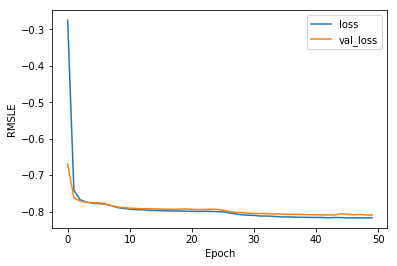

In [134]:
from matplotlib import pyplot as plt
plt.plot(results.epoch, np.log(results.history['loss']), label='loss')
plt.plot(results.epoch, np.log(results.history['val_loss']), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.legend()
plt.show()

In [135]:
model.load_weights('weights1.h5')

In [136]:
y_test_hat = model.predict(X_test)
print 'Test MSE: {}'.format(mean_squared_error(y_test, y_test_hat))

Test MSE: 8875779.72139


In [137]:
test_loss = []
for yt, yth in zip(y_test, y_test_hat):
    diff = np.log(yt + 1.) - np.log(yth + 1.)
    test_loss.append(diff ** 2)
print np.sqrt(np.mean(test_loss))

0.445852


In [138]:
np.min(y_test_hat)

0.0

In [29]:
test_features = preprocess(TEST_FILE)

In [93]:
test_features['bearing'] = test_features['bearing']/360.
test_features['h_dist'] = np.log(test_features['h_dist'] + 1.0)
test_features['cluster_dist'] = np.log(test_features['cluster_dist'] + 1.0)

In [94]:
for feature in categorical_features:
    dummies = pd.get_dummies(test_features[feature], prefix=feature, drop_first=False)
    test_features = pd.concat([test_features, dummies], axis=1)

In [96]:
fields_to_drop_test = fields_to_drop
fields_to_drop_test.remove(u'dropoff_datetime')
fields_to_drop_test.remove(u'trip_duration')
test_ = test_features.drop(fields_to_drop_test, axis=1)

In [139]:
pred = model.predict(test_.as_matrix())
print pred.shape

(625134, 1)


In [98]:
with open('predictions.txt', 'w') as _file:
    _file.write('id,trip_duration\n')
    for tid, p in zip(test_features['id'], pred):
        # tid, pred = example[0], model.predict(np.array([example[1:]]))
        p = p[0]
        _file.write('{},{}\n'.format(tid, p))

In [140]:
p = pd.DataFrame(pred)
p.describe()

,0
count,625134.000000
mean,787.463928
std,542.794678
min,0.000000
25%,413.795303
50%,642.543396
75%,996.449768
max,7325.944336


In [141]:
z = pd.DataFrame(y_train)
z.describe()

,trip_duration
count,1.166915e+06
mean,9.632583e+02
std,5.656109e+03
min,1.000000e+00
25%,3.970000e+02
50%,6.620000e+02
75%,1.075000e+03
max,3.526282e+06


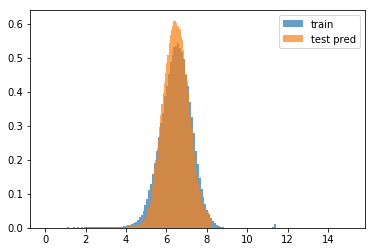

In [143]:
plt.hist(np.log(y_train + 1.0), bins=150, alpha=0.7, label='train', normed=True)
plt.hist(np.log(pred + 1.0), bins=150, alpha=0.7, label='test pred', normed=True)
plt.legend(loc='upper right')
plt.show()